In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import IPython.display as ipd

import soundfile as sf
import librosa
from data_utils import MudNoise
from model_stft import Mud, Mudv3
import json
import os
import torch
from torch import nn
from torch.autograd import Variable
import csv
from sep_eval import sep_eval as se
from librosa import stft
plt.style.use('dark_background')

In [2]:
datadir = '/Data/DATASETS/WSJ/mud_noise/'
validation_data_path = datadir + 'cv/debug_mud_v1.h5'

data_verbose = MudNoise(validation_data_path, noisedir='/Data/DATASETS/NoiseX/8k/', task='cv')

In [48]:
def load_mask_model(load, base_dir='.'):
    json_dir = base_dir + '/exp/' + load
    with open(json_dir + '/architecture.json', 'r') as fff:
        p = json.load(fff)
        load_path = json_dir + '/net/' + 'cv/'

        model = Mud(n_fft=p['nfft'], kernel=(p['kernel1'], p['kernel2']), causal=p['causal'],
                                layers=p['layers'], stacks=p['stacks'], verbose=False)

        mdl_idx = sorted([int(l.split('_')[-1].split('.')[0]) for l in os.listdir(load_path)])[-1]

        model.load_state_dict(torch.load(load_path + 'model_weight_{}.pt'.format(mdl_idx)))
        _ = model.eval()
        return model, p

mdl, _ = load_mask_model('201903104652_baseline2_C')

In [49]:
mix, s1 = data_verbose[1000]
mix = Variable(mix[:4]).contiguous()
recon = mdl(mix.unsqueeze(0))

m = mix.data.cpu().numpy()
s = s1.data.cpu().numpy()
r = recon.squeeze().data.cpu().numpy()
print(np.isnan(r))
ipd.display(ipd.Audio(m, rate=8000))
ipd.display(ipd.Audio(r, rate=8000))

print(se.sdr(r, m[0]))
print(se.sdr(r, s[0]))

[False False False ... False False False]


-2.7394724
10.301019


In [8]:
print(recon)

tensor([[-0.0027, -0.0027, -0.0024,  ...,  0.0407,  0.0428,  0.0411]],
       grad_fn=<DivBackward0>)


In [ ]:
# (all files)
all_files_names = []
all_traces = []
all_mics = []
all_nspk = {}
with open("/Data/Dropbox/cocoha_workshop_zh/cocoha_code/automated_exps/output_session2_15s.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    
    for i, line in enumerate(reader):
        all_nspk[line[0]] = int(line[-1])
        all_traces.append(line[5:-1])
        all_mics.append(line[1:5])
        all_files_names.append(line[0])

print(len(all_files_names))

5: 48 seconds		6: 48 seconds		7: 48 seconds		8: 48 seconds		Noise 3    [MAX = 22s]
Removing trigger => [45 ~= 45]


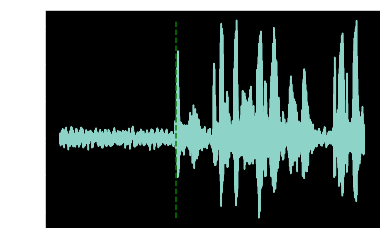

In [50]:
def find_trigger_v2(x):
    Y = x
    X = stft(Y)
    Y = np.log10(np.abs(X) ** 2 + 1e-8)
    YY = np.sum(Y, 0)
    n90 = np.percentile(YY, 65)
    tr = np.where(YY >= n90)[0][0]
    return tr * 512

name = '20190222110333'
all_data = []
t_in_secs = []
fs = 8000
for i in [5, 6, 7, 8]:
#     _fs, _y = wavfile.read('../data_whisper/session2/test_%s_wh%d.wav' % (name, i))
    _y, _fs = librosa.load('/Data/Dropbox/cocoha_workshop_zh/cocoha_code/data_whisper/session2/test_%s_wh%d.wav' % (name, i), sr=8000, mono=False)
    _y = _y.T.astype('float32')
    all_data.append(_y)
    assert(_fs == fs)
    t_in_secs.append(_y.shape[0] // fs)
    print("%d: %d seconds" % (i, _y.shape[0] // fs), end='\t\t')

# n_spk = all_nspk[name]
n_spk = 1
# print("N SPK: {}".format(n_spk))
m_len = np.min([a.shape[0] for a in all_data])
all_data_cut = [a[:m_len] for a in all_data]
all_data_array = np.hstack(all_data_cut) #.astype('float32')


t = np.arange(len(all_data_array[:, 0])) / fs

for_trigger = all_data_array[:, 6]
trigger = find_trigger_v2(for_trigger)
noise_calib = all_data_array[:trigger]
# noise_calib = NOISE_CALIB
print("Noise {}    [MAX = 22s]".format(len(noise_calib) // fs))
calib1 = all_data_array[0 * fs + trigger: 10 * fs + trigger]
calib2 = all_data_array[15 * fs + trigger: 25 * fs + trigger]
calib3 = all_data_array[30 * fs + trigger: 40 * fs + trigger]
calib4 = all_data_array[45 * fs + trigger: 55 * fs + trigger]

rec = all_data_array[max((15 * n_spk), 30) * fs + trigger:]
# rec = all_data_array[60 * fs + trigger:]


print("Removing trigger => [{} ~= {}]".format(t_in_secs[0] - trigger // fs, max((15 * n_spk), 30) + 15))

plt.plot(for_trigger[:trigger + 5 * fs])
plt.plot([trigger, trigger], [np.min(for_trigger[:trigger + 5 * fs]), np.max(for_trigger[:trigger + 5 * fs])], 'g--')

In [51]:
ipd.display(ipd.Audio(rec[:, 0], rate=8000))
ipd.display(ipd.Audio(calib1[:, 0], rate=8000))

In [52]:
mix = Variable(torch.from_numpy(rec.T[:8])).contiguous()
recon = mdl(mix.unsqueeze(0))

ipd.display(ipd.Audio(calib1[:, 0], rate=8000))
ipd.display(ipd.Audio(rec[:, 0], rate=8000))
ipd.display(ipd.Audio(recon.squeeze().data.cpu().numpy(), rate=8000))

# Try to load the full WHISPER dataset (ENH)

In [53]:
def find_trigger_v2(x):
    Y = x
    X = stft(Y)
    Y = np.log10(np.abs(X) ** 2 + 1e-8)
    YY = np.sum(Y, 0)
    n90 = np.percentile(YY, 65)
    tr = np.where(YY >= n90)[0][0]
    return tr * 512

In [55]:
timestamps = []
speakers = []
valids = []
all_nspk = {}

with open("/Data/Dropbox/cocoha_workshop_zh/cocoha_code/automated_exps/output_session2_15s_only_enh.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        all_nspk[line[0]] = int(line[-1])
        timestamps.append(line[0])
        speakers.append(np.array(line[1:5]))
        _traces = line[5:-1]
        valids.append(np.array(np.where(np.array(_traces) != '/Users/enea/DATASETS/Noise/silence.wav')[0]))


In [60]:
all_samples = []

for name in timestamps:
    sample = {}
    print(name)
    all_data = []
    t_in_secs = []
    fs = 8000
    for i in [5, 6, 7, 8]:
        _y, _fs = librosa.load('/Data/Dropbox/cocoha_workshop_zh/cocoha_code/data_whisper/session2/test_%s_wh%d.wav' % (name, i), sr=8000, mono=False)
        _y = _y.T.astype('float32')
        all_data.append(_y)
        assert(_fs == fs)
        t_in_secs.append(_y.shape[0] // fs)
#         print("%d: %d seconds" % (i, _y.shape[0] // fs), end='\t\t')

    n_spk = all_nspk[name]
    m_len = np.min([a.shape[0] for a in all_data])
    all_data_cut = [a[:m_len] for a in all_data]
    all_data_array = np.hstack(all_data_cut) #.astype('float32')


    t = np.arange(len(all_data_array[:, 0])) / fs

    for_trigger = all_data_array[:, 6]
    trigger = find_trigger_v2(for_trigger)
    noise_calib = all_data_array[:trigger]
    # noise_calib = NOISE_CALIB
    print("\tNoise {}    [MAX = 22s]".format(len(noise_calib) // fs))
    calib1 = all_data_array[0 * fs + trigger: 10 * fs + trigger]
    calib2 = all_data_array[15 * fs + trigger: 25 * fs + trigger]
    calib3 = all_data_array[30 * fs + trigger: 40 * fs + trigger]
    calib4 = all_data_array[45 * fs + trigger: 55 * fs + trigger]
    calib = [calib1, calib2]

    rec = all_data_array[max((15 * n_spk), 30) * fs + trigger:]
    
    if any([c.shape[0] != 10 * fs for c in calib]) or rec.shape[0] < 10 * fs:
        print('\t!!!Check trigger!!!')
        continue
    
    sample['rec'] = rec
    sample['calib_voice'] = calib1
    sample['calib_noise'] = calib2
    
    all_samples.append(sample)
    
    print("\tRemoving trigger => [{} ~= {}]".format(t_in_secs[0] - trigger // fs, max((15 * n_spk), 30) + 15))

#     plt.plot(for_trigger[:trigger + 5 * fs])
#     plt.plot([trigger, trigger], [np.min(for_trigger[:trigger + 5 * fs]), np.max(for_trigger[:trigger + 5 * fs])], 'g--')

20190222101012
	Noise 13    [MAX = 22s]
	Removing trigger => [48 ~= 45]
20190222101120
	Noise 15    [MAX = 22s]
	Removing trigger => [45 ~= 45]
20190222101228
	Noise 18    [MAX = 22s]
	Removing trigger => [47 ~= 45]
20190222101552
	Noise 4    [MAX = 22s]
	Removing trigger => [45 ~= 45]
20190222101700
	Noise 7    [MAX = 22s]
	Removing trigger => [45 ~= 45]
20190222101808
	Noise 8    [MAX = 22s]
	Removing trigger => [46 ~= 45]
20190222102133
	Noise 16    [MAX = 22s]
	Removing trigger => [45 ~= 45]
20190222102241
	Noise 19    [MAX = 22s]
	Removing trigger => [45 ~= 45]
20190222102349
	Noise 2    [MAX = 22s]
	Removing trigger => [42 ~= 45]
20190222102457
	Noise 3    [MAX = 22s]
	Removing trigger => [44 ~= 45]
20190222102605
	Noise 5    [MAX = 22s]
	Removing trigger => [45 ~= 45]
20190222102713
	Noise 8    [MAX = 22s]
	Removing trigger => [44 ~= 45]
20190222102821
	Noise 10    [MAX = 22s]
	Removing trigger => [46 ~= 45]
20190222103254
	Noise 20    [MAX = 22s]
	!!!Check trigger!!!
2019022210

In [63]:
import pickle as pkl

pkl.dump(all_samples, open('session_2_enh.pkl', 'wb'))

In [62]:
mdl.cuda()
s = all_samples[0]

mix = Variable(torch.from_numpy(s['rec'].T[:8])).contiguous().cuda()
recon = mdl(mix.unsqueeze(0))

ipd.display(ipd.Audio(s['calib_voice'][:, 0], rate=8000))
ipd.display(ipd.Audio(s['rec'][:, 0], rate=8000))
ipd.display(ipd.Audio(recon.squeeze().data.cpu().numpy(), rate=8000))

RuntimeError: CUDA out of memory. Tried to allocate 67.38 MiB (GPU 0; 10.91 GiB total capacity; 5.13 GiB already allocated; 72.50 MiB free; 248.06 MiB cached)